# DIGIT RECOGNISER - COMPUTER VISION
---
Esslingen University of Applied Sciences; Application Project by IGNATIUS TANG HONG-QUAN<br>
Supervising Professor: PROFESSOR KAI WARENDORF<br>
Dataset from Kaggle: Digit Recogniser, Learn computer vision fundamentals with the famous MNIST data<br>
Source: https://www.kaggle.com/competitions/digit-recognizer/data

---
## 1. Setup: Importing the Dataset: (using tensorflow backend)


In [1]:
#Import Libraries

import pandas as pd #data processing, CSV file I/O(e.g. pd.read_csv)
import numpy as np #linear algebra

#Data Visualisation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

#Tensorflow backend
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer


np.random.seed(2)

#Model and Performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

#CNN, Tensorflow, Keras
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau



sns.set(style='white', context='notebook', palette='deep')


C:\Users\Lenovo ThinkBook 14\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


---
## 2. Data Preparation

### 2.1 Load Data

In [2]:
# Load the data
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

C:\Users\Lenovo ThinkBook 14\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

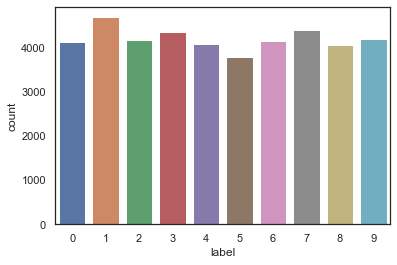

In [3]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

# creates countplot diagram from Y_train
g = sns.countplot(Y_train)

Y_train.value_counts()

^ We have similar counts for all `10` digits.

### 2.2 Check for null and missing values

In [4]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

Both `train` and `test` data count = 784 > No missing values, dataset is free of corrupted images, safe to proceed.

### 2.3 Normalisation

Perform greyscale normalisation to reduce the effect of illumination's differences.<br>
Moreover the CNN converge faster on [0..1] data than on [0..255].


In [6]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

### 2.4 Reshape

In [7]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

`train` and `test` images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are grey-scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

### 2.5 Label Encoding

In [8]:
# Encode labels to one hot vectors (eg : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

Labels are `10` digits numbers from `0` to `9`. We need to encode these labels to one hot vectors (eg : 2 -> [0,0,1,0,0,0,0,0,0,0]).

### 2.6 Split Training and Validation Set

In [9]:
# Set the random seed
random_seed = 2

In [10]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

I chose to split the `train` set in two parts:<br>
- a small fraction (10%) became the validation set which the model is evaluated and<br> 
- the rest (90%) is used to train the model.<br>

Since we have 42,000 training images of balanced labels (see 2.1 Load data), a random split of the `train` set does not cause some labels to be over-represented in the validation set. 


###### Example for a train dataset 

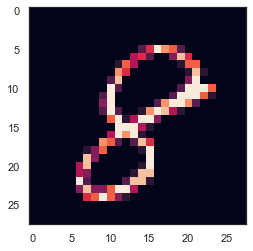

In [11]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

##### Examples for raw train datasets 

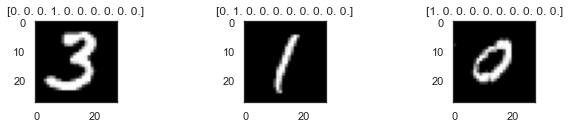

In [12]:
# Convert train dataset to (num_images, img_rows, img_cols) format 
X_train = X_train.reshape(X_train.shape[0], 28, 28)

# Set the figure size
plt.figure(figsize=(10, 6))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Plot the images
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.title(str(Y_train[i]))

plt.show()

---
## 3. CNN

### 3.1 Define the Model

Using Keras Sequential API, I just have to add one layer at a time, starting from the input.

>The first is the **convolutional (Conv2D) layer**. It is like a set of learnable filters. I chose to set *32 filters for the first two conv2D layers* and *64 filters for the last two*. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.


The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

>The second important layer in CNN is the **pooling (MaxPool2D) layer**. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

>`Dropout` is a regularisation method, where a proportion of nodes in the layer are randomly ignored (setting their weights to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalisation and reduces the overfitting.

>`relu` is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end, I used the features in <ins>two fully-connected (Dense) layers which is just an Artificial Neural Networks(ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class</ins>.

In [13]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

### 3.2 Set the Optimizer and Annealer

Once the layers are added to the model, I need to set up a `score function`, a `loss function` and an `optimization algorithm`.

We define the `loss function` to measure how *poorly our model performs on images with known labels*. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".

The most important function is the `optimizer`. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss.
>I chose **RMSprop** (with default values), it is a very effective optimizer. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. We could also have used Stochastic Gradient Descent ('SGD') optimizer, but it is slower than RMSprop.

The metric function "*accuracy*" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [14]:
from tensorflow.keras.optimizers import RMSprop

# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)


In [15]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, I used an **Annealing method of the learning rate (LR)**.

The `LR` is the step by which the optimizer walks through the '*loss landscape*'. <ins>The higher LR, the bigger are the steps and the quicker is the convergence</ins>. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

>Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

>To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the **ReduceLROnPlateau** function from Keras.callbacks, I chose to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [16]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [17]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

### 3.3 Data Augmentation¶

In order to the avoid overfitting problem, I need to artificially expand the handwritten digit dataset. The concept involves applying minor transformations to the training data to replicate the variations that arise during the process of writing a digit.

>For example, the number is not centered, the magnitude scale is not the same, the image is not oriented the same etc.

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Reshape the input data to include the channel dimension
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)

# With data augmentation to prevent overfitting (accuracy 0.99286)
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

datagen.fit(X_train)

Augmentation:
* Randomly rotate some training images by 10 degrees
* Randomly Zoom by 10% some training images
* Randomly shift images horizontally by 10% of the width
* Randomly shift images vertically by 10% of the height
<br>

*I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symmetrical numbers such as 6 and 9.*

Once the model is ready, fit the training dataset .

In [19]:
# Fit the model using Model.fit
history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    epochs=epochs, validation_data=(X_val, Y_val),
                    verbose=2, steps_per_epoch=X_train.shape[0] // batch_size,
                    callbacks=[learning_rate_reduction])


Epoch 1/30


439/439 - 23s - loss: 0.4164 - accuracy: 0.8659 - val_loss: 0.0750 - val_accuracy: 0.9750 - lr: 0.0010 - 23s/epoch - 53ms/step
Epoch 2/30
439/439 - 22s - loss: 0.1246 - accuracy: 0.9632 - val_loss: 0.0560 - val_accuracy: 0.9824 - lr: 0.0010 - 22s/epoch - 50ms/step
Epoch 3/30
439/439 - 22s - loss: 0.0942 - accuracy: 0.9716 - val_loss: 0.0291 - val_accuracy: 0.9905 - lr: 0.0010 - 22s/epoch - 50ms/step
Epoch 4/30
439/439 - 22s - loss: 0.0748 - accuracy: 0.9779 - val_loss: 0.0339 - val_accuracy: 0.9902 - lr: 0.0010 - 22s/epoch - 50ms/step
Epoch 5/30
439/439 - 22s - loss: 0.0679 - accuracy: 0.9793 - val_loss: 0.0355 - val_accuracy: 0.9886 - lr: 0.0010 - 22s/epoch - 51ms/step
Epoch 6/30
439/439 - 22s - loss: 0.0638 - accuracy: 0.9819 - val_loss: 0.0399 - val_accuracy: 0.9883 - lr: 0.0010 - 22s/epoch - 51ms/step
Epoch 7/30
439/439 - 22s - loss: 0.0596 - accuracy: 0.9820 - val_loss: 0.0299 - val_accuracy: 0.9921 - lr: 0.0010 - 22s/epoch - 50ms/step
Epoch 8/30
439/439 - 24s - loss:

Epoch 27/30
439/439 - 31s - loss: 0.0594 - accuracy: 0.9849 - val_loss: 0.0307 - val_accuracy: 0.9936 - lr: 0.0010 - 31s/epoch - 71ms/step
Epoch 28/30
439/439 - 31s - loss: 0.0638 - accuracy: 0.9842 - val_loss: 0.0311 - val_accuracy: 0.9929 - lr: 0.0010 - 31s/epoch - 71ms/step
Epoch 29/30
439/439 - 32s - loss: 0.0655 - accuracy: 0.9842 - val_loss: 0.0264 - val_accuracy: 0.9943 - lr: 0.0010 - 32s/epoch - 72ms/step
Epoch 30/30
439/439 - 31s - loss: 0.0664 - accuracy: 0.9839 - val_loss: 0.0342 - val_accuracy: 0.9936 - lr: 0.0010 - 31s/epoch - 71ms/step


## 4. Model Evaluation

---
### 4.1 Training and Validation Curves

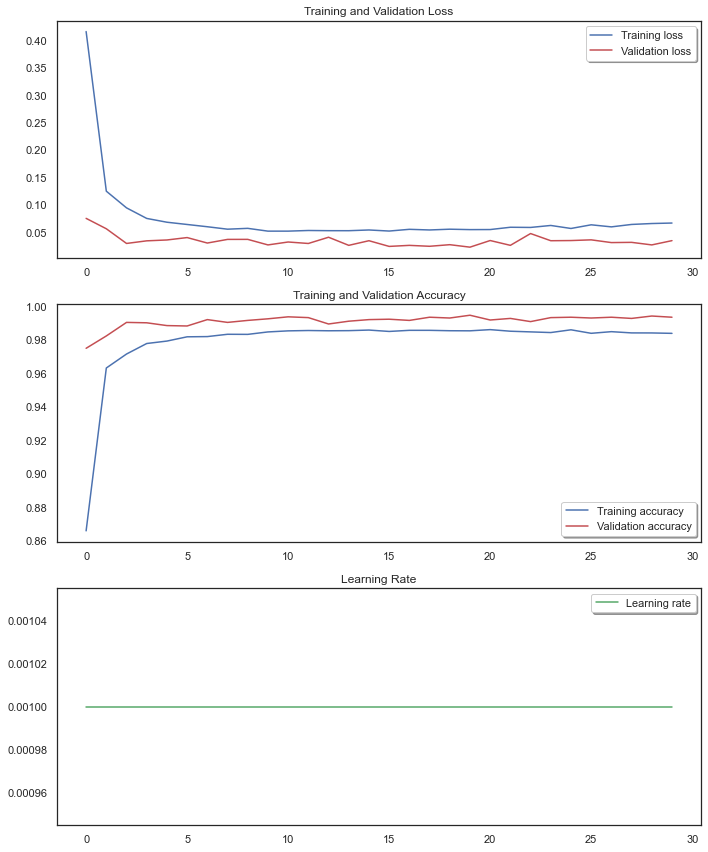

In [20]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

# Plot training and validation loss
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
ax[0].legend(loc='best', shadow=True)
ax[0].set_title('Training and Validation Loss')

# Plot training and validation accuracy
ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax[1].legend(loc='best', shadow=True)
ax[1].set_title('Training and Validation Accuracy')

# Plot learning rate (if available in the history)
if 'lr' in history.history:
    ax[2].plot(history.history['lr'], color='g', label="Learning rate")
    ax[2].legend(loc='best', shadow=True)
    ax[2].set_title('Learning Rate')

# Display the plot
plt.tight_layout()
plt.show()


In [21]:
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


### 4.2 Confusion matrix

Confusion matrix can be very helpful to see your model drawbacks.

Plot the confusion matrix of the validation results.

132/132 [==============================] - 1s 8ms/step


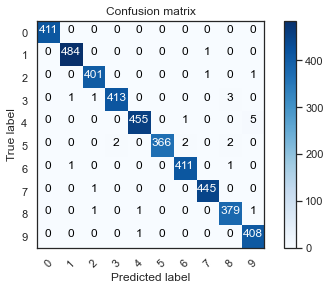

In [22]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

Here we can see that our CNN performs very well on all digits with few errors considering the size of the validation set (4 200 images).

However, it seems that our CNN has some little troubles with the 4 digits, they are misclassified as 9. Sometimes it is very difficult to catch the difference between 4 and 9 when curves are smooth.

Let's investigate for errors.

I want to see the most important errors. For that purpose I need to get the difference between the probabilities of real value and the predicted ones in the results.

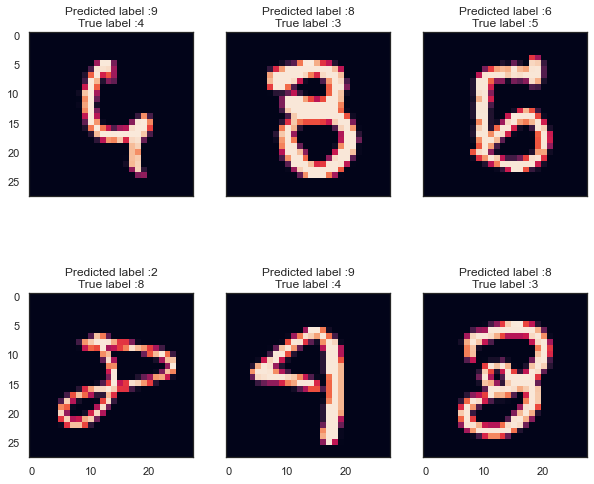

In [23]:
# Display some error results 

# Error difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(10, 8))
    fig.subplots_adjust(hspace=0.5) 
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]).reshape((28, 28)))
            ax[row, col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error], obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

The most important errors are also the most intricate. For these six cases, the model is not absurd. Some of these errors can also be made by humans.

In [24]:
# predict results
results = model.predict(test)

# select the index with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

875/875 [==============================] - 7s 8ms/step


In [25]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)


---
## 5. Prediction of Organic Dataset

### Testing the New Dataset
---
Save the trained model for testing.

In [28]:
loaded_model = keras.models.load_model("trained_cnn_model.h5")

loaded_model.save("trained_cnn_model.h5")

C:\Users\Lenovo ThinkBook 14\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


I compiled 3 unique sets of handwritten digits from 0-9 and ran the model against this new loaded image.<br>
The images had to be mannually **cropped**, **recentered** and **resized** to `28x28pixels` which I have done in pre-processing.

[Processing new images]

1/1 [==============================] - 0s 14ms/step


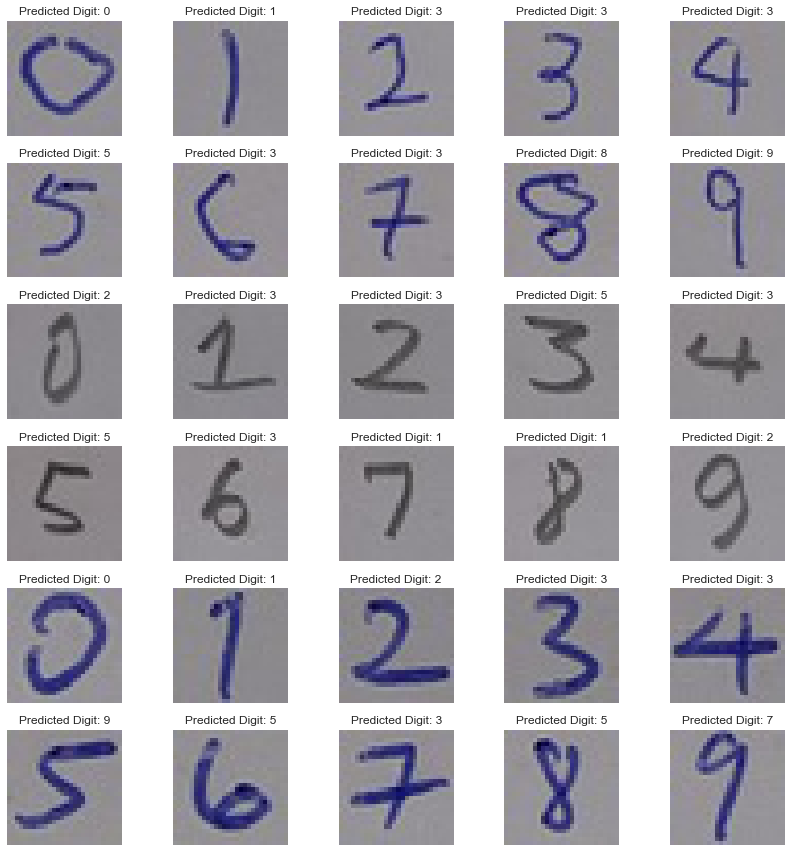

In [32]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import matplotlib.pyplot as plt

# dimensions of our images
img_width, img_height = 28, 28

# load the model we saved
model = load_model('trained_cnn_model.h5')
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(img_width, img_height), color_mode="grayscale")
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x

# Path to the own_dataset directory
dataset_path = 'own_dataset'

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(dataset_path) if f.endswith('.jpg')]

# Set up the subplot grid
num_rows = 6
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Predict for each image in the dataset
for i, image_file in enumerate(image_files):
    img_path = os.path.join(dataset_path, image_file)
    x = load_and_preprocess_image(img_path)
    predictions = model.predict(x, batch_size=1)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Display the image in the subplot
    ax = axes[i // num_cols, i % num_cols]
    img = image.load_img(img_path, target_size=(img_width, img_height))
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Predicted Digit: {predicted_class}")
    ax.axis('off')

# Adjust layout to prevent clipping
plt.tight_layout()
plt.show()


###### From the results above, our model successfully predicted all the numbers that I have written using different hands, medium and colour.<br>
###### This model can be further built upon to automatically recognise numbers or alphabets and hence texts in an input image.